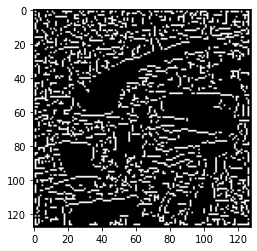

In [9]:
#-*- coding:utf-8 -*-
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 畳み込み演算（空間フィルタリング）
def filter2d(src, kernel, fill_value=-1):
    # カーネルサイズ
    m, n = kernel.shape

    # 畳み込み演算をしない領域の幅
    d = int((m-1)/2)
    h, w = src.shape[0], src.shape[1]

    # 出力画像用の配列
    if fill_value == -1:
        dst = src.copy()
    elif fill_value == 0:
        dst = np.zeros((h, w))
    else:
        dst = np.zeros((h, w))
        dst.fill(fill_value)

    for y in range(d, h - d):
        for x in range(d, w - d):
            # 畳み込み演算
            dst[y][x] = np.sum(src[y-d:y+d+1, x-d:x+d+1]*kernel)

    return dst


# Non maximum Suppression処理
def non_max_sup(G, Gth):

    h, w = G.shape
    dst = G.copy()

    # 勾配方向を4方向(垂直・水平・斜め右上・斜め左上)に近似
    Gth[np.where((Gth >= -22.5) & (Gth < 22.5))] = 0
    Gth[np.where((Gth >= 157.5) & (Gth < 180))] = 0
    Gth[np.where((Gth >= -180) & (Gth < -157.5))] = 0
    Gth[np.where((Gth >= 22.5) & (Gth < 67.5))] = 45
    Gth[np.where((Gth >= -157.5) & (Gth < -112.5))] = 45
    Gth[np.where((Gth >= 67.5) & (Gth < 112.5))] = 90
    Gth[np.where((Gth >= -112.5) & (Gth < -67.5))] = 90
    Gth[np.where((Gth >= 112.5) & (Gth < 157.5))] = 135
    Gth[np.where((Gth >= -67.5) & (Gth < -22.5))] = 135

    # 注目画素と勾配方向に隣接する2つの画素値を比較し、注目画素値が最大でなければ0に
    for y in range(1, h - 1):
        for x in range(1, w - 1):
            if Gth[y][x] == 0:
                if (G[y][x] < G[y][x+1]) or (G[y][x] < G[y][x-1]):
                    dst[y][x] = 0
            elif Gth[y][x] == 45:
                if (G[y][x] < G[y-1][x+1]) or (G[y][x] < G[y+1][x-1]):
                    dst[y][x] = 0
            elif Gth[y][x] == 90:
                if (G[y][x] < G[y+1][x]) or (G[y][x] < G[y-1][x]):
                    dst[y][x] = 0
            else:
                if (G[y][x] < G[y+1][x+1]) or (G[y][x] < G[y-1][x-1]):
                    dst[y][x] = 0
    return dst


# Hysteresis Threshold処理
def hysteresis_threshold(src, t_min=75, t_max=150, d=1):

    h, w = src.shape
    dst = src.copy()

    for y in range(0, h):
        for x in range(0, w):
            # 最大閾値より大きければ信頼性の高い輪郭
            if src[y][x] >= t_max:
                dst[y][x] = 255
            # 最小閾値より小さければ信頼性の低い輪郭(除去)
            elif src[y][x] < t_min:
                dst[y][x] = 0
            # 最小閾値～最大閾値の間なら、近傍に信頼性の高い輪郭が1つでもあれば輪郭と判定、無ければ除去
            else:
                if np.max(src[y-d:y+d+1, x-d:x+d+1]) >= t_max:
                    dst[y][x] = 255
                else:
                    dst[y][x] = 0

    return dst


def canny_edge_detecter(gray, t_min, t_max, d):

    # 処理1 ガウシアンフィルタで平滑化
    kernel_g = np.array([[1/16, 1/8, 1/16],
                         [1/8,  1/4,  1/8],
                         [1/16, 1/8, 1/16]])

    # ガウシアンフィルタ
    G = filter2d(gray, kernel_g, -1)

    # 処理2 微分画像の作成（Sobelフィルタ）
    kernel_sx = np.array([[-1, 0, 1],
                          [-2, 0, 2],
                          [-1, 0, 1]])

    kernel_sy = np.array([[-1, -2, -1],
                          [0,  0, 0],
                          [1, 2, 1]])
                          
    Gx = filter2d(G, kernel_sx, 0)
    Gy = filter2d(G, kernel_sy, 0)

    # 処理3 勾配強度・方向を算出
    G = np.sqrt(Gx**2 + Gy**2)
    Gth = np.arctan2(Gy, Gx) * 180 / np.pi

    # 処理4 Non maximum Suppression処理
    G = non_max_sup(G, Gth)

    # 処理5 Hysteresis Threshold処理
    return hysteresis_threshold(G, t_min, t_max, d)

def BGR2GRAY(img):
    b = img[:, :, 0].copy()
    g = img[:, :, 1].copy()
    r = img[:, :, 2].copy()

    # Gray scale
    out = 0.2126 * r + 0.7152 * g + 0.0722 * b
    out = out.astype(np.uint8)

    return out

# 入力画像を読み込み
img = cv2.imread("../imori.jpg")

 # グレースケール変換  ここは問題ではない
gray = BGR2GRAY(img)    
#gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# 方法1(NumPyで実装)
edge1 = canny_edge_detecter(gray, 20,50, 1)

# 結果を出力

plt.imshow(edge1, cmap='gray')


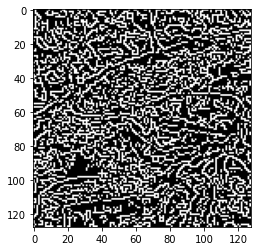

In [14]:
#-*- coding:utf-8 -*-
import cv2
import numpy as np

# 入力画像を読み込み
img = cv2.imread("../imori.jpg")

# グレースケール変換
#gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = BGR2GRAY(img)    
# 方法2(OpenCVで実装)
dst2 = cv2.Canny(gray, 20, 50)

# 結果を出力
plt.imshow(dst, cmap='gray')

In [23]:
np.sum(np.abs(dst1-dst2), axis=(-1))

array([1278, 1533,  515, 1027, 1535,  517,  516, 1023,  261,  514,  769,
       1281, 1534, 1025, 1025, 1024,  515, 1541, 1534, 1278,  770,  513,
        773, 1788,  519, 1277, 1276,  768, 1277, 1023,  770, 1277, 1025,
       1530,  517, 1533,  773, 1534, 1536, 1275, 1026, 1021, 1277, 1276,
        513,  516,  514, 1023, 1023,  256,  259,  512,  512,  256, 1022,
        512,  513, 1532, 1026, 1022, 1278,  513,  768,  769, 1534, 1021,
        769,  768, 1535, 1277, 1278, 1276,  768,  513, 1024,  767,  770,
       1534, 1023,  513,  768, 1024, 1277, 1025, 2806, 1536, 1531, 1281,
          3,  768, 1278, 1278,  257, 1534, 1533, 1280, 1277, 2300,  518,
       1023, 1533, 1531, 2044, 1531, 1536,  257, 1023, 1533,  768, 1277,
        514,  257,  257, 1026,  768,  768, 2043, 2297, 2806, 3319, 1021,
        257, 1790,  514,  772, 1022,  769, 1278], dtype=uint64)

In [ ]:
# gray scaleの時点で実装が違う